<a href="https://colab.research.google.com/github/scpark20/KimchiSpeech_KSS/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 설치

In [1]:
!pip install parallel-wavegan --quiet
!pip install g2pk --quiet
!pip install jamotools --quiet

     |████████████████████████████████| 68 kB 4.9 MB/s 
     |████████████████████████████████| 124 kB 17.7 MB/s 
     |████████████████████████████████| 596 kB 62.0 MB/s 
     |████████████████████████████████| 19.4 MB 9.1 MB/s 
     |████████████████████████████████| 448 kB 34.8 MB/s 
     |████████████████████████████████| 211 kB 46.6 MB/s 
  ERROR: Failed building wheel for python-mecab-ko
    Running setup.py install for python-mecab-ko ... done
  DEPRECATION: python-mecab-ko was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


### Parallel WaveGAN 초기화

In [2]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "kss_parallel_wavegan.v1"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()

from parallel_wavegan.utils import read_hdf5

stats_filename = "/root/.cache/parallel_wavegan/kss_parallel_wavegan.v1/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')


Downloading...
From: https://drive.google.com/uc?id=1mLtQAzZHLiGSWguKCGG0EZa4C_xUO5gX
To: /root/.cache/parallel_wavegan/kss_parallel_wavegan.v1.tar.gz
100%|██████████| 15.8M/15.8M [00:00<00:00, 72.8MB/s]


done


### clone KimchiSpeech for KSS 

In [3]:
!git clone https://github.com/scpark20/KimchiSpeech_KSS.git
import os
import torch
os.chdir('KimchiSpeech_KSS')

Cloning into 'KimchiSpeech_KSS'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 5), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [5]:
!ls

demo.ipynb  kimchispeech_kss_80000.chkpnt  model.py	README.md
hparams.py  LICENSE			   __pycache__	TruncatedNormal.py


### KimchiSpeech 초기화

In [6]:
from model import Model
from hparams import create_hparams
_, hp = create_hparams()
model = Model(hp)
model = model.cuda()
model.eval()

checkpoint = torch.load('kimchispeech_kss_80000.chkpnt', map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'])
print('done')

done


### Text 입력

In [15]:
from g2pk import G2p
import jamotools as jt

g2p = G2p()
v = jt.Vectorizationer(rule=jt.rules.RULE_1, max_length=None)

text = "안녕하세요? 반갑습니다. 저는 에이 아이로 만들어진 음성입니다."
#text = "주어와 서술어는 호응하지 않고, 문장은 엿가락처럼 길기만 합니다. 게다가 문맥에 어울리지 않는 한자어를 남발하는 바람에 내용 파악조차 어렵습니다. 서술형 답안을 작성하고, 논술 시험을 대비하는 학생들의 글에서 흔히 발견하는 문제입니다."
text = "동작 그만, 밑장빼기냐? 내가 빙다리 핫바지로 보이냐?"
#text = "배우들의 열연과 인상 깊은 대사 덕분에 패러디와 합성소재로 쓰이기도 한다."
#text = "소년은 개울가에서 소녀를 보자 곧 윤초시네 증손녀딸이라는 걸 알 수 있었다. 소녀는 개울에다 손을 잠그고 물장난을 하고 있는 것이다. 서울서는 이런 개울물을 보지 못하기나 한 듯이."
#text = "오미크론 대유행으로 신규 확진자가 5만명 이상으로 불어난 상황에서도 정부가 사회적 거리두기 등 방역 조치를 오히려 완화하려는 듯한 메시지를 지속해서 보내고 있다."
text = ' ' + text
phonemes = g2p(text)
jamos = jt.split_syllables(phonemes)
tokens = v.vectorize(phonemes)
print('phonemes :', phonemes)
print('jamos :', jamos)
print('tokens :', tokens)

phonemes :  동작 끄만, 믿짱빼기냐? 내가 빙다리 핟빠지로 보이냐?
jamos :  ㄷㅗㅇㅈㅏㄱ ㄲㅡㅁㅏㄴ, ㅁㅣㄷㅉㅏㅇㅃㅐㄱㅣㄴㅑ? ㄴㅐㄱㅏ ㅂㅣㅇㄷㅏㄹㅣ ㅎㅏㄷㅃㅏㅈㅣㄹㅗ ㅂㅗㅇㅣㄴㅑ?
tokens : [105   5  29  62  14  21  42 105   3  39   8  21  45 107 105   8  41  48
  15  21  62  10  22   2  41   4  23   1 105   4  22   2  21 105   9  41
  62   5  21   7  41 105  20  21  48  10  21  14  41   7  29 105   9  29
  13  41   4  23   1]


### Text-to-Speech

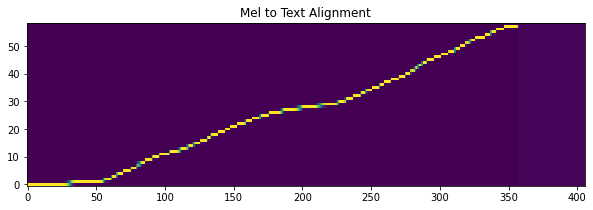

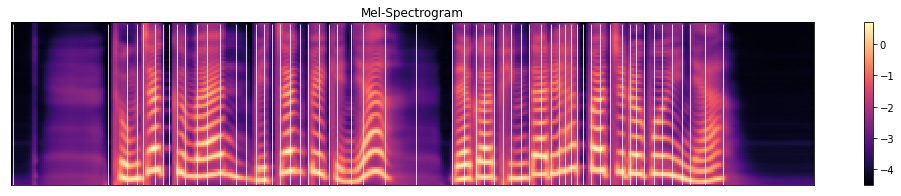

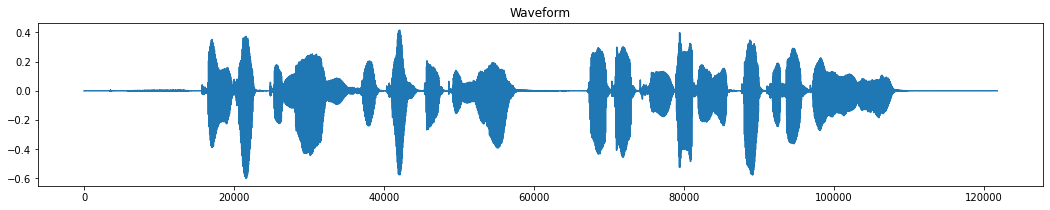

In [16]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

with torch.no_grad():
    samples, alignments, _ = model.inference(torch.from_numpy(tokens).cuda().long().unsqueeze(0),
                                 temperature=1.0, clip=1.0, speed=1.0)
    
_s = samples.data.cpu().numpy()
_mels = _s[0]
_mels = np.maximum(_mels, -5)

_alignment = alignments[0].data.cpu().numpy()
plt.figure(figsize=[10, 3])
plt.title('Mel to Text Alignment')
plt.imshow(_alignment, aspect='auto', origin='lower', interpolation='none')
plt.show()

plt.figure(figsize=[18, 3])
plt.title('Mel-Spectrogram')
librosa.display.specshow(_mels)
plt.vlines(_alignment.argmax(axis=1), ymin=0, ymax=79, color='white', linewidth=1, alpha=0.8)
plt.colorbar()
plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = (_mels.T - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    
plt.figure(figsize=[18, 3])
plt.title('Waveform')
plt.plot(_wav)
plt.show()
    
import IPython.display as ipd
ipd.Audio(_wav, rate=24000)

### 한글 자모 alignment

In [17]:
def tick_to_time(tick, hop=300, sr=24000):
    time_per_tick = hop / sr
    return tick * time_per_tick

for jamo, array in zip(jamos, _alignment):
    tick = np.argmax(array)
    time = tick_to_time(tick)
    print(jamo, '%.2f' % time)

  0.01
ㄷ 0.61
ㅗ 0.74
ㅇ 0.80
ㅈ 0.84
ㅏ 0.91
ㄱ 0.96
  1.00
ㄲ 1.05
ㅡ 1.10
ㅁ 1.18
ㅏ 1.24
ㄴ 1.33
, 1.43
  1.49
ㅁ 1.55
ㅣ 1.60
ㄷ 1.65
ㅉ 1.70
ㅏ 1.76
ㅇ 1.83
ㅃ 1.88
ㅐ 1.95
ㄱ 2.01
ㅣ 2.06
ㄴ 2.15
ㅑ 2.23
? 2.36
  2.56
ㄴ 2.79
ㅐ 2.86
ㄱ 2.94
ㅏ 2.99
  3.05
ㅂ 3.11
ㅣ 3.16
ㅇ 3.23
ㄷ 3.28
ㅏ 3.35
ㄹ 3.41
ㅣ 3.46
  3.50
ㅎ 3.54
ㅏ 3.58
ㄷ 3.61
ㅃ 3.66
ㅏ 3.73
ㅈ 3.79
ㅣ 3.86
ㄹ 3.91
ㅗ 3.95
  4.00
ㅂ 4.06
ㅗ 4.11
ㅇ 4.17
ㅣ 4.24
ㄴ 4.29
ㅑ 4.39
? 4.50
